Phân Tích Và Nhận Dạng Mẫu (Pattern Recognition)

Fruits and Vegetables Image Recognition Dataset

I. Nạp dữ liệu

1.Tải dataset

Tải thư viện

In [127]:
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import seaborn as sns
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import math


# Tắt cảnh báo không cần thiết
warnings.simplefilter("ignore", UserWarning)


--- TEST ---
Số lớp: 36
Tổng số ảnh trong test: 359

--- TRAIN ---
Số lớp: 36
Tổng số ảnh trong train: 3115

--- VALIDATION ---
Số lớp: 36
Tổng số ảnh trong validation: 351


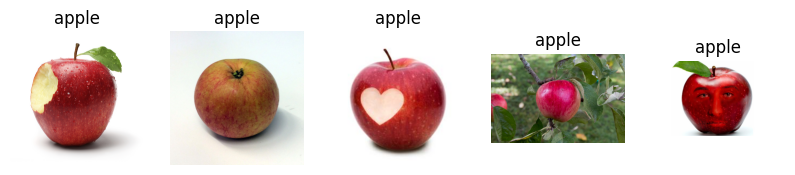

In [128]:

base_dir = r"C:/Users/ADMIN/Desktop/Pattern Recognition/archive"

folders = ["test", "train", "validation"]
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    classes = [c for c in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, c))]
    print(f"\n--- {folder.upper()} ---")
    print(f"Số lớp: {len(classes)}")
    
    total_images = 0
    for c in classes:
        c_path = os.path.join(folder_path, c)
        num_imgs = len(os.listdir(c_path))
        total_images += num_imgs
    print(f"Tổng số ảnh trong {folder}: {total_images}")

# Hiển thị vài ảnh mẫu từ train
sample_class = classes[0]
sample_path = os.path.join(base_dir, "train", sample_class)
sample_images = os.listdir(sample_path)[:5]

plt.figure(figsize=(10, 5))
for i, img_name in enumerate(sample_images):
    img = mpimg.imread(os.path.join(sample_path, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(sample_class)
plt.show()

2.Cấu trúc dữ liệu

In [129]:
data_summary = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    classes = sorted([c for c in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, c))])
    
    for cls in classes:
        cls_path = os.path.join(folder_path, cls)
        num_imgs = len(os.listdir(cls_path))
        data_summary.append([cls, folder, num_imgs])

# Tạo DataFrame
df_summary = pd.DataFrame(data_summary, columns=["Class", "Set", "Num_Images"])

# Tổng số ảnh mỗi class
df_total = df_summary.groupby("Class")["Num_Images"].sum().reset_index().rename(columns={"Num_Images": "Total_Images"})

# Gộp lại
df_full = df_summary.merge(df_total, on="Class")

print(df_full)

           Class         Set  Num_Images  Total_Images
0          apple        test          10            88
1         banana        test           9            93
2       beetroot        test          10           108
3    bell pepper        test          10           109
4        cabbage        test          10           112
..           ...         ...         ...           ...
103    sweetcorn  validation          10           111
104  sweetpotato  validation          10            89
105       tomato  validation          10           112
106       turnip  validation          10           118
107   watermelon  validation          10           104

[108 rows x 4 columns]


II.Tiền xử lý dữ liệu

In [130]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
base_dir = r"C:/Users/ADMIN/Desktop/Pattern Recognition/archive"  


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,        # tăng rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7,1.3],  # thay đổi độ sáng
    fill_mode='nearest'
)

# Validation & Test chỉ chuẩn hóa
test_val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory=f"{base_dir}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'  # dùng sparse_categorical_crossentropy
)

val_generator = test_val_datagen.flow_from_directory(
    directory=f"{base_dir}/validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_val_datagen.flow_from_directory(
    directory=f"{base_dir}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Số lớp: {num_classes}")





Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.
Số lớp: 36


III.Trực quan hóa dữ liệu

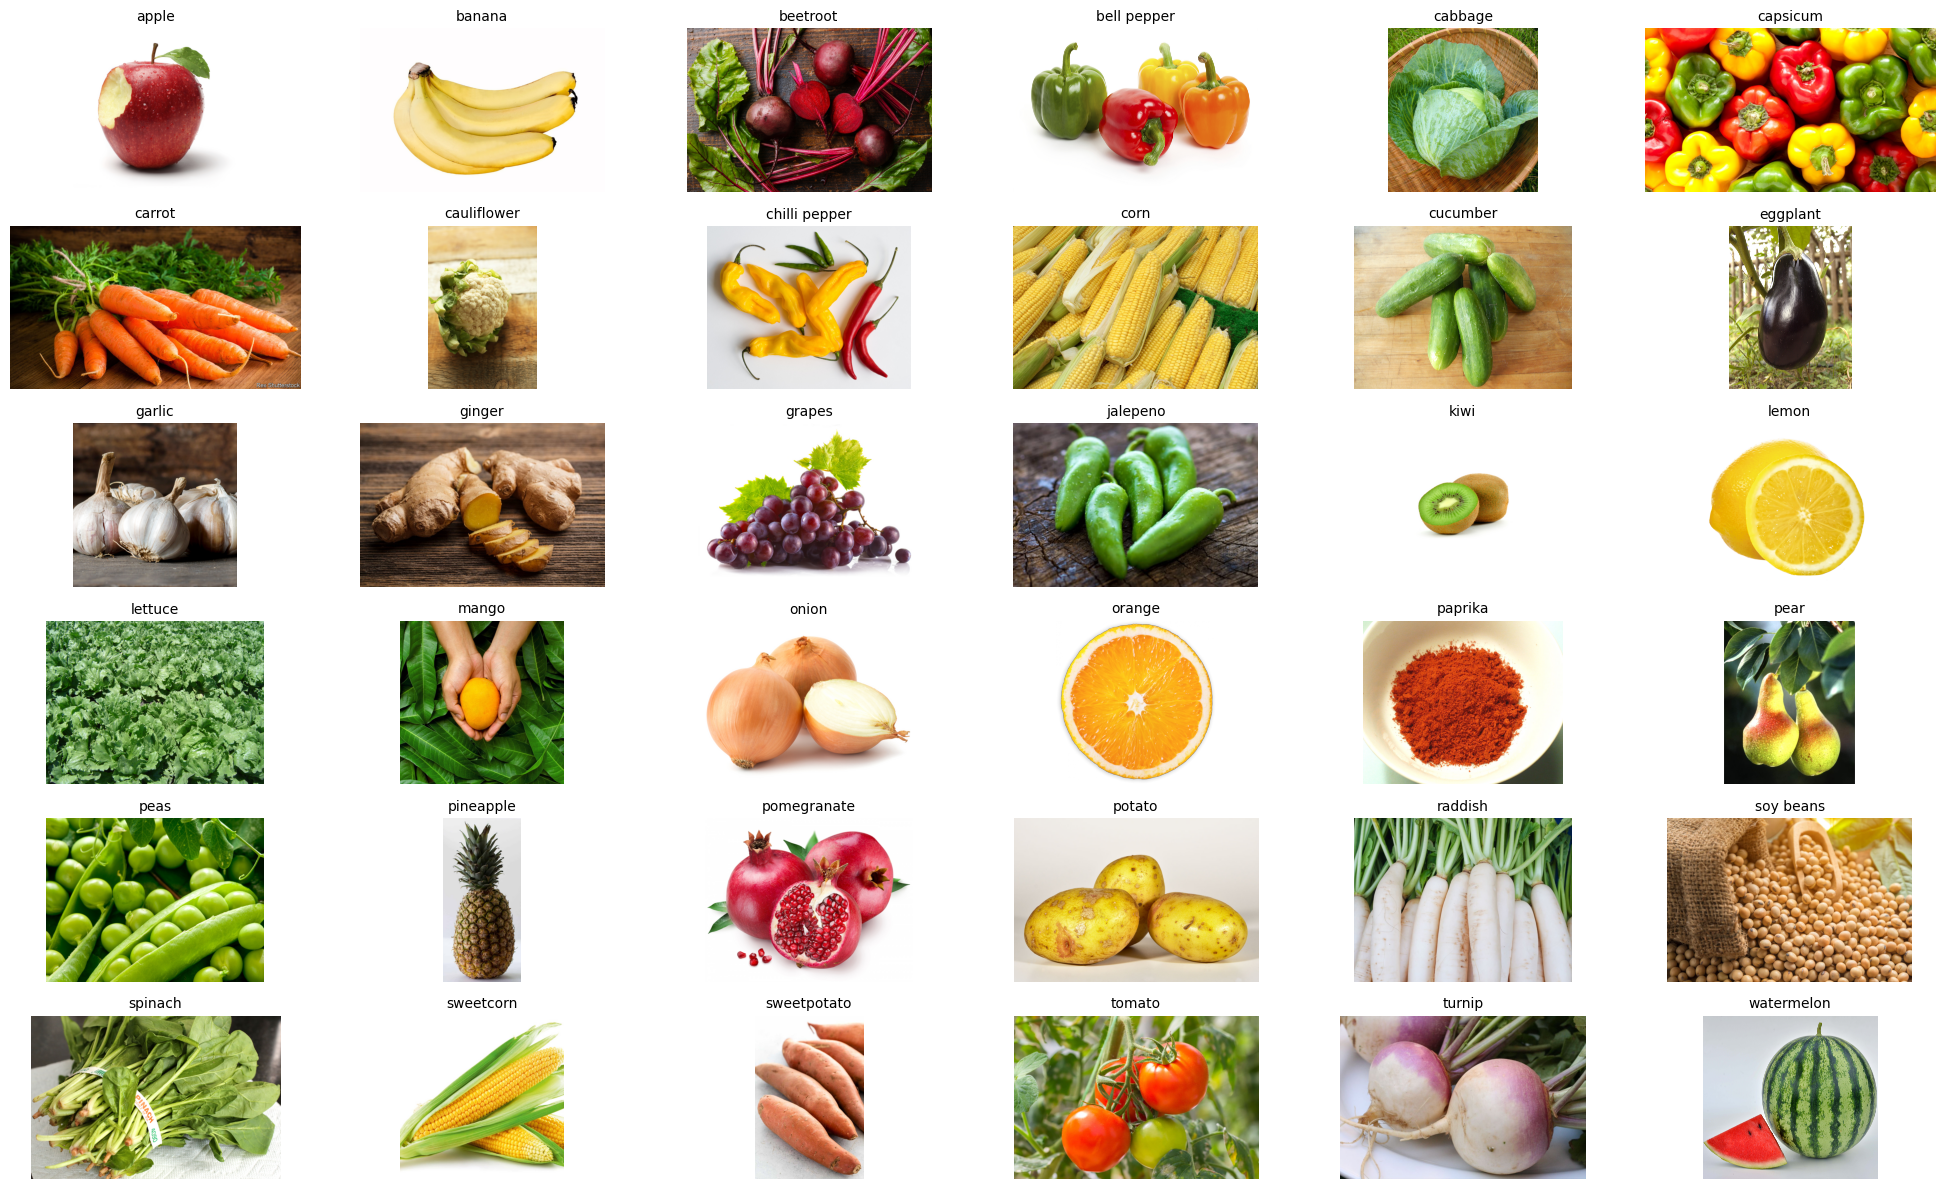

In [131]:
def show_class_gallery(base_dir, imgs_per_class=1, cols=6, figsize=(20, 12)):
    
    class_names = sorted(os.listdir(base_dir))
    n_classes = len(class_names)
    rows = math.ceil(n_classes / cols)
    
    plt.figure(figsize=figsize)
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(base_dir, class_name)
        img_files = os.listdir(class_path)[:imgs_per_class]
        img_path = os.path.join(class_path, img_files[0])  # lấy ảnh đầu tiên
        img = mpimg.imread(img_path)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(class_name, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("", fontsize=20)
    plt.show()


show_class_gallery("C:/Users/ADMIN/Desktop/Pattern Recognition/archive/train")  





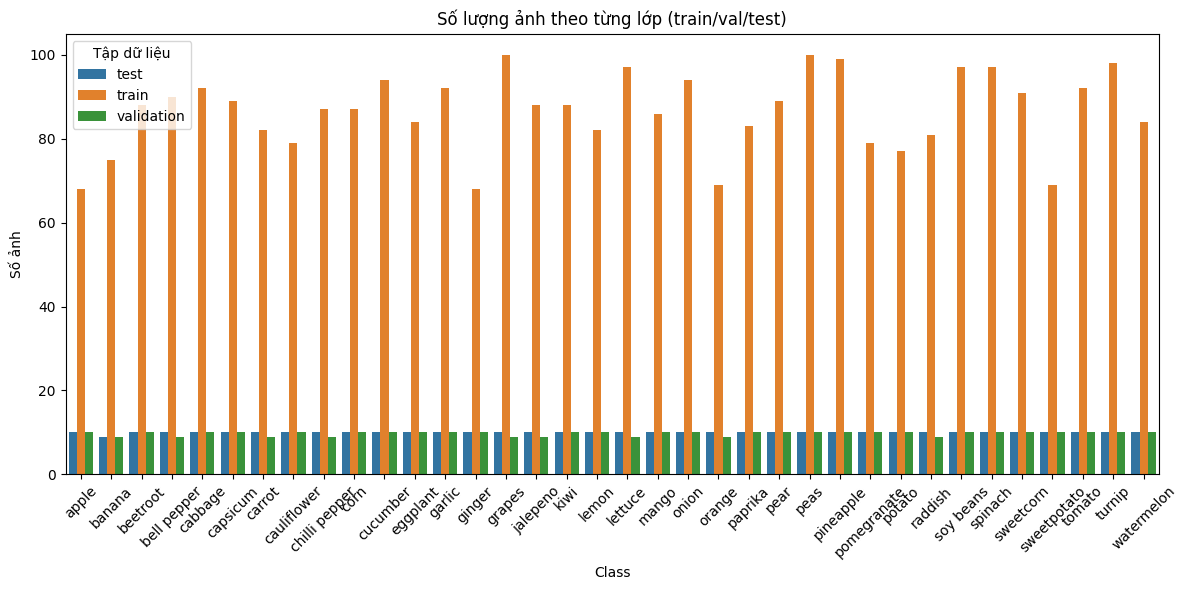

In [132]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_full, x="Class", y="Num_Images", hue="Set")
plt.xticks(rotation=45)
plt.title("Số lượng ảnh theo từng lớp (train/val/test)")
plt.ylabel("Số ảnh")
plt.xlabel("Class")
plt.legend(title="Tập dữ liệu")
plt.tight_layout()
plt.show()


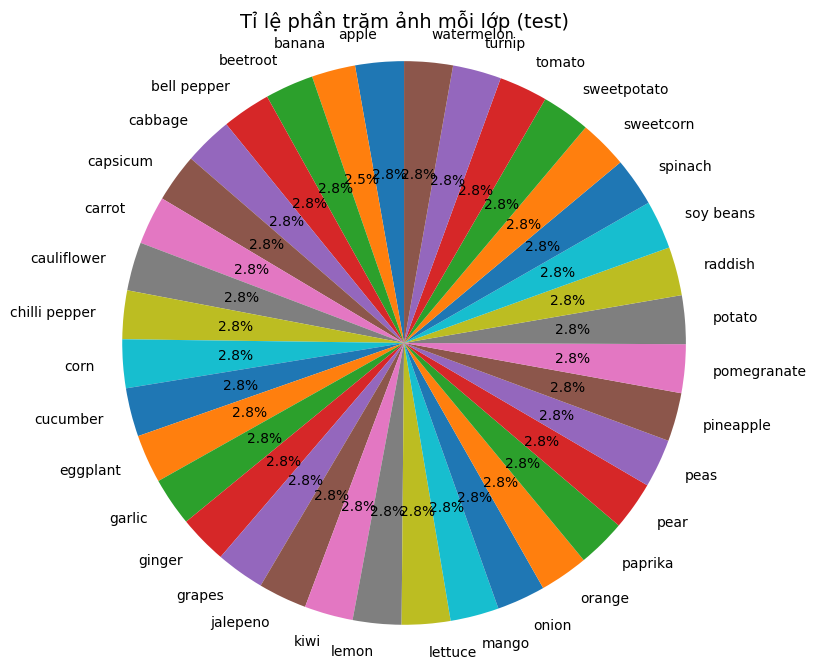

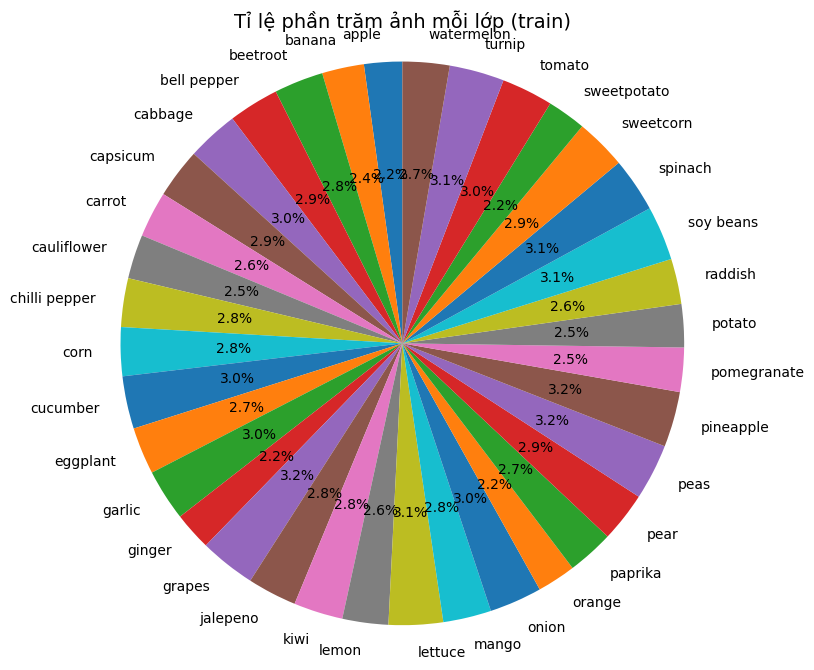

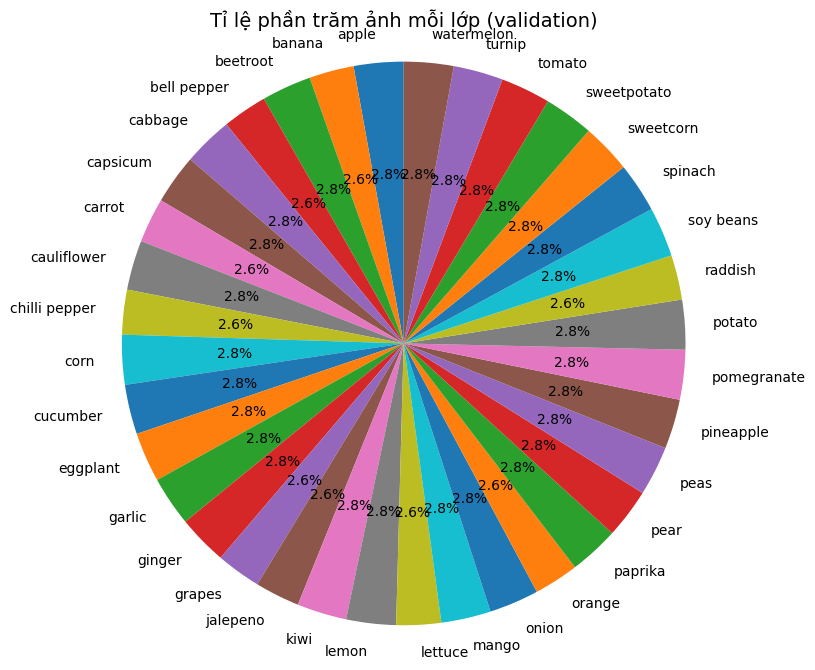

In [133]:
# Lấy danh sách các tập
sets = df_full["Set"].unique()

for s in sets:
    df_subset = df_full[df_full["Set"] == s]

    plt.figure(figsize=(8, 8))
    plt.pie(
        df_subset["Num_Images"],
        labels=df_subset["Class"],
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.title(f"Tỉ lệ phần trăm ảnh mỗi lớp ({s})", fontsize=14)
    plt.axis("equal")  # Giữ hình tròn
    plt.show()


IV.Huấn luyện mô hình

1.Xây dựng mô hình CNN

In [134]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),

    layers.Dense(num_classes, activation='softmax',
                 kernel_regularizer=regularizers.l2(0.001))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 36)             │        18,468 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,436 (2.07 MB)

 Trainable params: 540,452 (2.06 MB)

 Non-trainable params: 1,984 (7.75 KB)

2.Huấn luyện mô hình

In [135]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

y_train = train_generator.classes
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict,  # <-- thêm vào đây
    verbose=1
)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.1502 - loss: 3.9481 - val_accuracy: 0.0427 - val_loss: 4.6595 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.2366 - loss: 3.4014 - val_accuracy: 0.0513 - val_loss: 4.9883 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2722 - loss: 3.2182 - val_accuracy: 0.0684 - val_loss: 4.6650 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.3156 - loss: 3.0234 - val_accuracy: 0.1538 - val_loss: 3.9215 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.3361 - loss: 2.8713 - val_accuracy: 0.3105 - val_loss: 2.9674 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.3640 - loss: 2.7711 - val_accuracy: 0.4188 - val_loss: 2.5396 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4080 - loss: 2.6030 - val_acc

3.Đánh giá mô hình

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 870ms/step - accuracy: 0.9359 - loss: 0.6508
Test Accuracy: 0.9359
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 952ms/step
               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       0.90      1.00      0.95         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       0.83      1.00      0.91        10
     capsicum       0.80      0.80      0.80        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.40      0.57        10
     cucumber       0.83      1.00      0.91        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00

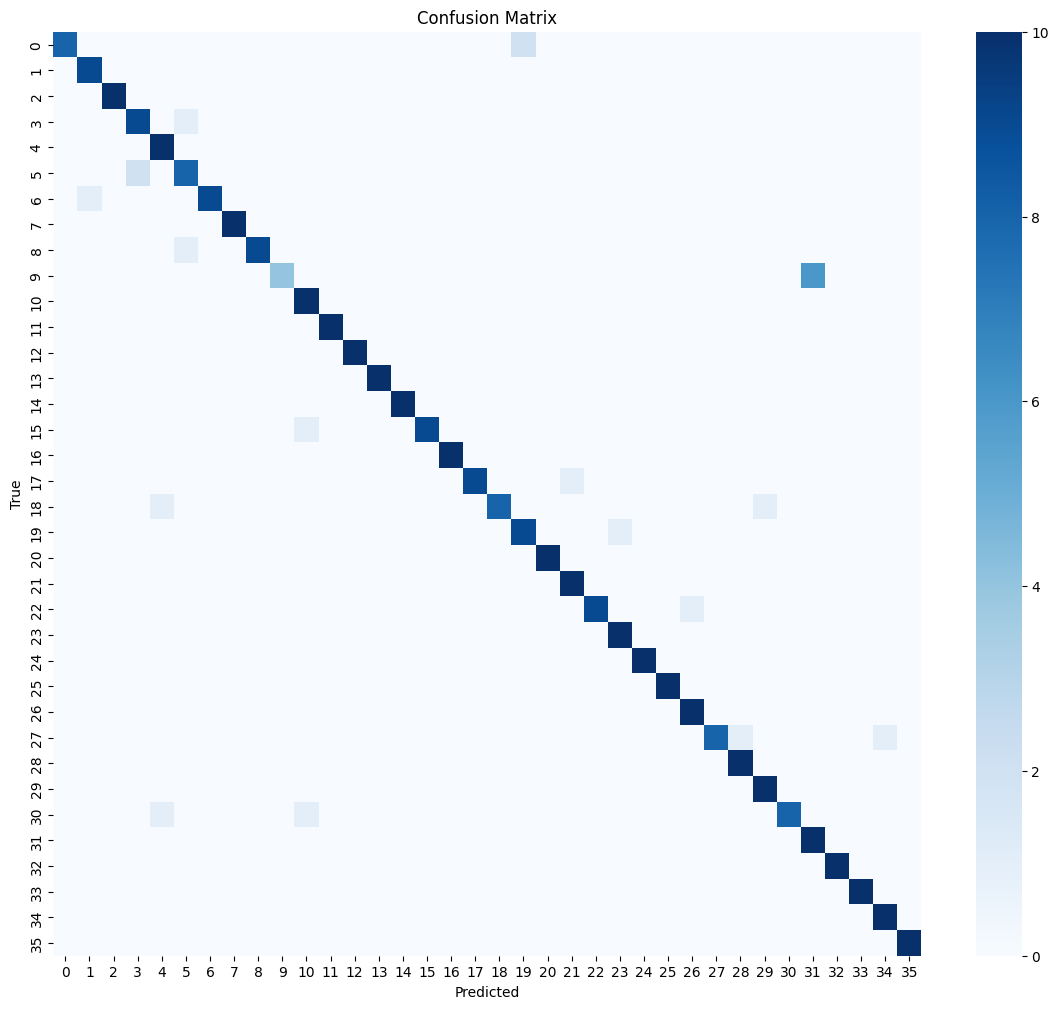

In [136]:
# Đánh giá trên test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


4.Lưu mô hình 

In [ ]:
model.save("C:/Users/ADMIN/Desktop/Pattern Recognition/cnn_fruits_vegetables.h5")


In [138]:
np.save("C:/Users/ADMIN/Desktop/Pattern Recognition/class_indices.npy", train_generator.class_indices)


V.Triển khai mô hình vào Web App Flask